## Contents

1. [Background](#Background)
1. [Goal](#GoalB)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background
**Model**: Ever heard about *Generative Adversarial Model* (GAN) ? How about *DeepFakes*? Many generative models nowadays use typical GAN architecture to model data distribution, then reconstruct and generate a completely new data.

We have seen many application of GAN such as face generation and face morphing. The underlying model behind GAN architecture that enables its generative capability is called *Variational Autoencoder* (VAE). Today we are going to take a look on how to build a simple Conditional VAE model.

**Dataset**: Kannada is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). TODO Kannada!!!!


## Goal
This tutorial will show you how to build and deploy on Sagemaker using Pytorch. The dataset we are using is the MNIST dataset. To get the feel, we will first see how a simple neural network can be used to generate a new handwritten digit image without human intervension. Then we will train and deploy our Pytorch model in Sagemaker environment.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.


---

## Setup 
_(Duration: 5 min)_

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).

---


In [3]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/workshop-pytorch-mnist'

role = sagemaker.get_execution_role()

### Packages

We will also setup our project by specifying libraries and modules that we need

In [10]:
import os, sys
import math
import json, logging, argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# visualisation
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Meet and Greet Data: Kaggle Kannada MNIST
_(Duration: 20 min)_


Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

In [7]:
data_dir = 'data/Kannada'

In [8]:
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print('data at: ' + os.path.join(dirname, filename))

data at: data/Kannada/test.csv
data at: data/Kannada/Dig-MNIST.csv
data at: data/Kannada/train.csv
data at: data/Kannada/sample_submission.csv


### Downloading Kaggle Dataset

In [2]:
%%bash
# Install Kaggle CLI using Python Pip
pip install --quiet kaggle
mkdir -p /home/ec2-user/.kaggle

# Copy API key file to where Kaggle expects it
# Make sure to upload the file next to this notebook
cp kaggle.json /home/ec2-user/.kaggle/ && chmod 600 /home/ec2-user/.kaggle/kaggle.json

# Download Kannada MNIST from Kaggle
kaggle competitions download -c Kannada-MNIST

# Unzip to data/Kannada directory
mkdir -p data/Kannada
unzip Kannada-MNIST.zip -d data/Kannada

### Loading Dataset with Pandas

In [17]:
from sklearn.model_selection import train_test_split

# Load Data
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'Dig-MNIST.csv'))
submission_set = pd.read_csv(os.path.join(data_dir, 'test.csv')).iloc[:,1:]

# Seperate train data and labels
train_data = train.drop('label',axis=1)
train_targets = train['label']

# Seperate test data and labels
test_images=test.drop('label',axis=1)
test_labels=test['label']

In [18]:
# Train Test Split for validation
train_images, val_images, train_labels, val_labels = train_test_split(train_data, 
                                                                     train_targets, 
                                                                     test_size=0.15)

In [22]:
# Reset Index
train_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

val_images.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

test_images.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

### The shape of Kannada dataset

I'm in lop with the shape op u

In [36]:
train_images.iloc[20000:20005, 200:320]

,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,...,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319
20000,0,0,0,0,0,0,0,0,0,32,...,0,0,0,0,0,0,0,0,0,0
20001,0,0,0,0,0,0,25,178,0,0,...,0,0,0,0,0,0,0,0,0,0
20002,0,0,0,0,0,0,255,0,0,255,...,0,0,0,0,0,0,0,0,0,255
20003,0,0,0,0,0,0,0,0,0,96,...,0,0,0,0,0,0,0,0,0,0
20004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,170,255,163,96


In [23]:
print("Train Set: \n" + '-'*20)
print(train_images.shape)
print(train_labels.shape)

Train Set: 
--------------------
(51000, 784)
(51000,)


In [48]:
val_images.iloc[8000:8005, 200:320]

,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,...,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319
8000,0,0,0,0,0,0,0,223,235,115,...,0,0,0,0,0,0,0,0,0,0
8001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8002,0,0,0,0,0,0,0,100,195,255,...,0,0,0,0,0,0,0,0,255,255
8003,0,0,0,0,0,0,232,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8004,0,0,0,0,0,204,58,32,32,32,...,0,0,0,0,0,0,255,255,35,0


In [24]:
print("\nValidation Set: \n"  + '-'*20)
print(val_images.shape)
print(val_labels.shape)


Validation Set: 
--------------------
(9000, 784)
(9000,)


In [49]:
test_images.iloc[5000:5005, 200:320]

,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,...,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319
5000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,98,157,189,255,255
5001,0,0,0,0,0,0,0,0,0,255,...,0,0,0,0,0,0,0,0,255,255
5002,0,0,0,0,0,0,0,173,100,0,...,0,0,0,0,0,0,0,0,0,0
5003,0,0,0,0,8,255,215,0,0,0,...,0,0,0,0,0,0,159,159,134,0
5004,0,0,0,0,159,223,32,159,223,32,...,0,0,0,0,13,13,214,255,255,244


In [27]:
print("\nTest Set: \n"  + '-'*20)
print(test_images.shape)
print(test_labels.shape)

print("\nSubmission: ")
print(submission_set.shape)


Test Set: 
--------------------
(10240, 784)
(10240,)

Submission: 
(5000, 784)


### Visualising Dataset Distribution

Let's look at the distribution of Kannada dataset across different classes.

In [26]:
train_dist = train_labels.value_counts(normalize = True)
submission_dist = test_labels.value_counts(normalize = True)

# display table for visualising dataset distribution
pd.DataFrame({
    'Train Distribution': train_dist,
    'Submission Distribution': submission_dist
})

,Train Distribution,Submission Distribution
0,0.099784,0.1
1,0.099725,0.1
2,0.100059,0.1
3,0.100706,0.1
4,0.100549,0.1
5,0.099039,0.1
6,0.100333,0.1
7,0.100647,0.1
8,0.099412,0.1
9,0.099745,0.1


## Pytorch Dataset Object & Data Loader

### Define Pytorch Dataset Object

In [37]:
class KannadaDataSet(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i,:]
        data = np.array(data).astype(np.uint8).reshape(IMGSIZE,IMGSIZE,1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

### Define Image Transformation Pipeline

In [38]:
IMGSIZE = 28

# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.RandomCrop(IMGSIZE),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(), # automatically divide by 255
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(), # automatically divide by 255
]))

### Define Pytorch Data Loader

In [39]:
batch_size = 64

# Initialise dataset object for each set
train_data = KannadaDataSet(train_images, train_labels, train_trans)
val_data   = KannadaDataSet(val_images, val_labels, val_trans)
test_data  = KannadaDataSet(test_images, test_labels, val_trans)
submission_data = KannadaDataSet(submission_set, None, val_trans)

# Define Dataloader for each set
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_data, 
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)

submission_loader = DataLoader(submission_data,
                               batch_size=batch_size,
                               shuffle=False)

### Visualise Image in Training Batch

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

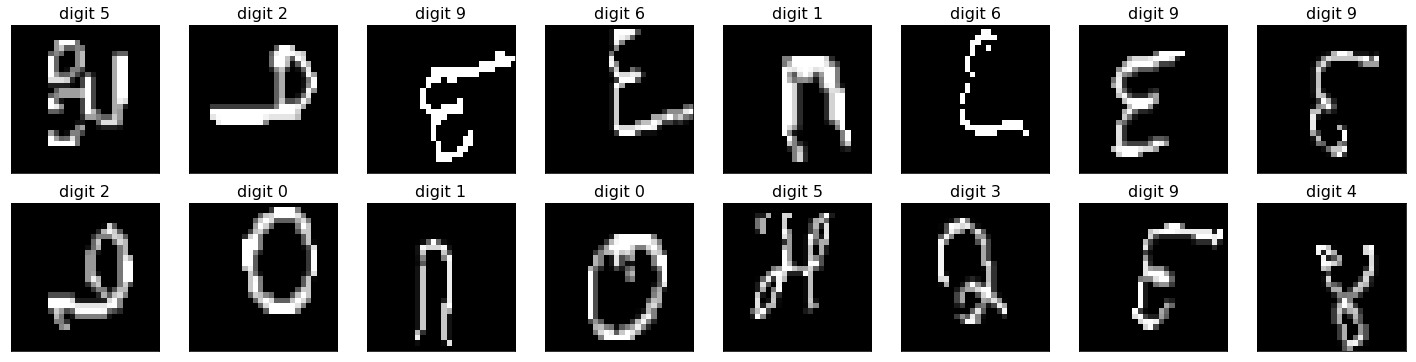

In [46]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title('digit ' + str(labels[idx].item()), fontsize=16)  # .item() gets single value in scalar tensor

### Visualise Image in Detail

Now let's see an image from MNIST dataset in detail. Notice how our image pixels only ranges from $(0, 1)$. This means that no further normalisation is required in the preprocessing step.

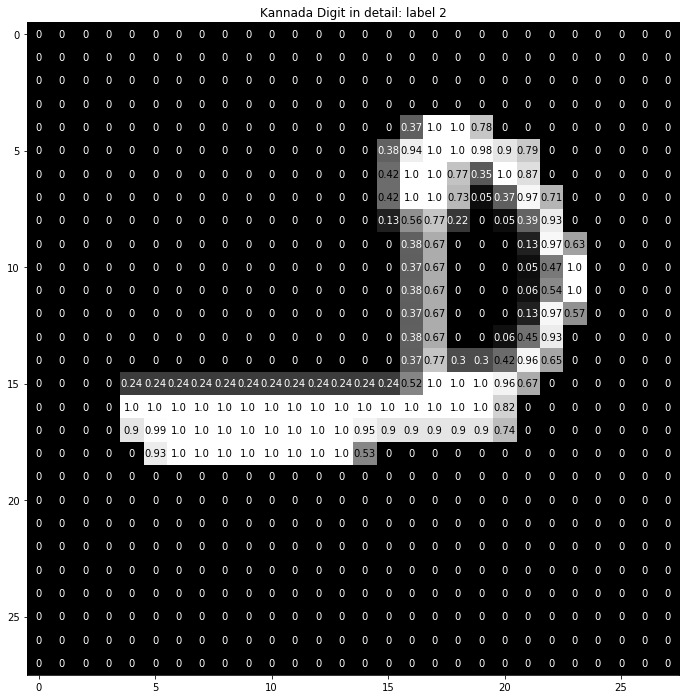

In [60]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

ax.set_title('Kannada Digit in detail: label %d' % labels[1].item());

### Uploading the data to S3

Next, we are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

In [110]:
# Save data to local folder first
train_images.to_csv(os.path.join(data_dir, 'train.csv'), index=False, header=False)
train_labels.to_csv(os.path.join(data_dir, 'train_labels.csv'), index=False, header=False)

val_images.to_csv(os.path.join(data_dir, 'validation.csv'), index=False, header=False)
val_labels.to_csv(os.path.join(data_dir, 'validation_labels.csv'), index=False, header=False)

test_images.to_csv(os.path.join(data_dir, 'test.csv'), index=False, header=False)
test_labels.to_csv(os.path.join(data_dir, 'test_labels.csv'), index=False, header=False)

In [111]:
s3_data_path = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('Data path/url in AWS S3 -> {}'.format(s3_data_path))

Data path/url in AWS S3 -> s3://sagemaker-ap-southeast-1-352716015230/sagemaker/workshop-pytorch-mnist


## Building and Training CNN Model
_(Duration: 25 min)_



In [137]:
class CNN(nn.Module):
    """
    """
    def __init__(self, drop_p=0.25):
        super().__init__()
        
        # First hidden layer
        self.conv2d_0 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.convbn_0 = nn.BatchNorm2d(num_features=64, momentum=0.9)

        self.conv2d_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.convbn_1 = nn.BatchNorm2d(num_features=64, momentum=0.9)

        self.conv2d_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.convbn_2 = nn.BatchNorm2d(num_features=64, momentum=0.9)

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_1 = nn.Dropout2d(p=drop_p)

        # Second hidden layer
        self.conv2d_3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.convbn_3 = nn.BatchNorm2d(num_features=128, momentum=0.9)

        self.conv2d_4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.convbn_4 = nn.BatchNorm2d(num_features=128, momentum=0.9)

        self.conv2d_5 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.convbn_5 = nn.BatchNorm2d(num_features=128, momentum=0.9)

        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_2 = nn.Dropout2d(p=drop_p)

        # Third hidden layer
        self.conv2d_6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convbn_6 = nn.BatchNorm2d(num_features=256, momentum=0.9)

        self.conv2d_7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.convbn_7 = nn.BatchNorm2d(num_features=256, momentum=0.9)

        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_3 = nn.Dropout2d(p=drop_p)

        
        self.dense_linear_1 = nn.Linear(256*3*3, 256)
        self.dense_bn_1 = nn.BatchNorm1d(num_features=256, momentum=0.1)
        self.dense_linear_2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv2d_0(x)
        x = self.convbn_0(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_1(x)
        x = self.convbn_1(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_2(x)
        x = self.convbn_2(x)
        x = F.leaky_relu(x)

        x = self.pool_1(x)
        x = self.drop_1(x)

        x = self.conv2d_3(x)
        x = self.convbn_3(x)
        x = F.leaky_relu(x)

        x = self.conv2d_4(x)
        x = self.convbn_4(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_5(x)
        x = self.convbn_5(x)
        x = F.leaky_relu(x)
        
        x = self.pool_2(x)
        x = self.drop_2(x)
        
        x = self.conv2d_6(x)
        x = self.convbn_6(x)
        x = F.leaky_relu(x)

        x = self.conv2d_7(x)
        x = self.convbn_7(x)
        x = F.leaky_relu(x)
        
        x = self.pool_3(x)
        x = self.drop_3(x)

        x = x.view(-1, 256*3*3)
        x = self.dense_linear_1(x)
        x = F.leaky_relu(x)
        x = self.dense_bn_1(x)

        out = self.dense_linear_2(x)
        return F.log_softmax(out)

In [138]:
from torchsummary import summary

In [139]:
model = CNN()

In [145]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,928
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 28, 28]         102,464
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
         Dropout2d-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
      BatchNorm2d-12          [-1, 128, 14, 14]             256
           Conv2d-13          [-1, 128, 14, 14]         409,728
      BatchNorm2d-14          [-1, 128,

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
